In [1]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
! gdown --id 19puyGgjEqjY8KwIxAiwQmppip4ETjOy3

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19puyGgjEqjY8KwIxAiwQmppip4ETjOy3
From (redirected): https://drive.google.com/uc?id=19puyGgjEqjY8KwIxAiwQmppip4ETjOy3&confirm=t&uuid=6f5e3ae2-a4e0-4915-970b-61b124dc2e4a
To: /content/data.zip
100% 459M/459M [00:06<00:00, 73.0MB/s]


In [3]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
 extracting: data/train_masks/0789bed99cb8_09_mask.gif  
 extracting: data/train_masks/0789bed99cb8_10_mask.gif  
 extracting: data/train_masks/0789bed99cb8_11_mask.gif  
 extracting: data/train_masks/0789bed99cb8_12_mask.gif  
  inflating: data/train_masks/0789bed99cb8_13_mask.gif  
  inflating: data/train_masks/0789bed99cb8_14_mask.gif  
 extracting: data/train_masks/0789bed99cb8_15_mask.gif  
 extracting: data/train_masks/0789bed99cb8_16_mask.gif  
 extracting: data/train_masks/0795e132d090_01_mask.gif  
 extracting: data/train_masks/0795e132d090_02_mask.gif  
 extracting: data/train_masks/0795e132d090_03_mask.gif  
 extracting: data/train_masks/0795e132d090_04_mask.gif  
 extracting: data/train_masks/0795e132d090_05_mask.gif  
 extracting: data/train_masks/0795e132d090_06_mask.gif  
 extracting: data/train_masks/0795e132d090_07_mask.gif  
 extracting: data/train_masks/0795e132d090_08_mask.gif  
 extracting: data/train_masks/0795e13

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision import transforms

class CarvanaDataset(Dataset):
    def __init__(self, root_path, test=False):
        self.root_path = root_path
        if test:
            self.images = sorted([root_path+"/manual_test/"+i for i in os.listdir(root_path+"/manual_test/")])
            self.masks = sorted([root_path+"/manual_test_masks/"+i for i in os.listdir(root_path+"/manual_test_masks/")])
        else:
            self.images = sorted([root_path+"/train/"+i for i in os.listdir(root_path+"/train/")])
            self.masks = sorted([root_path+"/train_masks/"+i for i in os.listdir(root_path+"/train_masks/")])

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()])

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask)

    def __len__(self):
        return len(self.images)

In [6]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)

In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
       down_1, p1 = self.down_convolution_1(x)
       down_2, p2 = self.down_convolution_2(p1)
       down_3, p3 = self.down_convolution_3(p2)
       down_4, p4 = self.down_convolution_4(p3)

       b = self.bottle_neck(p4)

       up_1 = self.up_convolution_1(b, down_4)
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return out

In [8]:
torch.cuda.empty_cache()

#print(torch.cuda.memory_usage())

In [9]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
if __name__ == "__main__":
    LEARNING_RATE = 3e-4
    BATCH_SIZE = 8
    EPOCHS = 1
    DATA_PATH = "/content/data"
    MODEL_SAVE_PATH = "/content/unet.pth"

    device = "cuda" if torch.cuda.is_available() else "cpu"
    train_dataset = CarvanaDataset(DATA_PATH)

    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

    train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

    model = UNet(in_channels=3, num_classes=1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in tqdm(range(EPOCHS)):
        model.train()
        train_running_loss = 0
        for idx, img_mask in enumerate(tqdm(train_dataloader)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            optimizer.zero_grad()

            loss = criterion(y_pred, mask)
            train_running_loss += loss.item()

            loss.backward()
            optimizer.step()

        train_loss = train_running_loss / (idx + 1)

        model.eval()
        val_running_loss = 0
        with torch.no_grad():
            for idx, img_mask in enumerate(tqdm(val_dataloader)):
                img = img_mask[0].float().to(device)
                mask = img_mask[1].float().to(device)

                y_pred = model(img)
                loss = criterion(y_pred, mask)

                val_running_loss += loss.item()

            val_loss = val_running_loss / (idx + 1)

        print("-"*30)
        print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
        print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
        print("-"*30)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)

 45%|████▌     | 231/509 [06:07<07:35,  1.64s/it]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 3.38 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

100%|██████████| 509/509 [13:51<00:00,  1.63s/it]

100%|██████████| 1/1 [16:00<00:00, 960.26s/it]


------------------------------
Train Loss EPOCH 1: 0.1634
Valid Loss EPOCH 1: 0.0479
------------------------------


<Figure size 1000x1000 with 0 Axes>

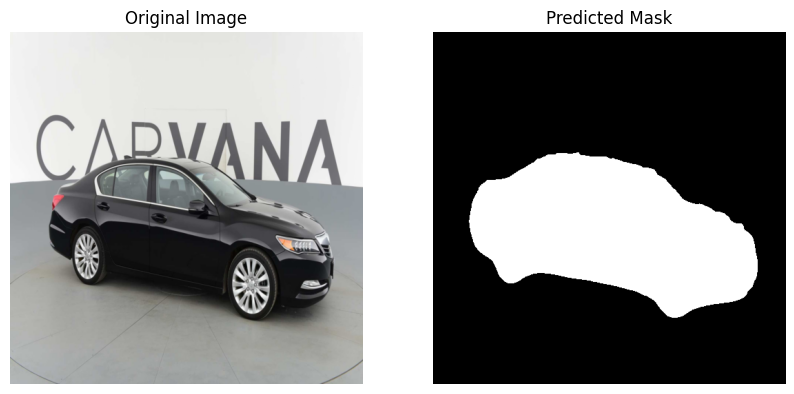

In [13]:
def pred_show_image_grid(data_path, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))
    image_dataset = CarvanaDataset(data_path, test=True)
    images = []
    orig_masks = []
    pred_masks = []

    for img, orig_mask in image_dataset:
        img = img.float().to(device)
        img = img.unsqueeze(0)

        pred_mask = model(img)

        img = img.squeeze(0).cpu().detach()
        img = img.permute(1, 2, 0)

        pred_mask = pred_mask.squeeze(0).cpu().detach()
        pred_mask = pred_mask.permute(1, 2, 0)
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1

        orig_mask = orig_mask.cpu().detach()
        orig_mask = orig_mask.permute(1, 2, 0)

        images.append(img)
        orig_masks.append(orig_mask)
        pred_masks.append(pred_mask)

    images.extend(orig_masks)
    images.extend(pred_masks)
    fig = plt.figure(figsize=(10, 10))

    total_images = len(images)
    grid_size = 3
    for i in range(total_images):
        fig.add_subplot(grid_size, total_images // grid_size, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.axis('off')
    plt.show()


def single_image_inference(image_pth, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()])

    img = transform(Image.open(image_pth)).float().to(device)
    img = img.unsqueeze(0)

    pred_mask = model(img)

    img = img.squeeze(0).cpu().detach()
    img = img.permute(1, 2, 0)

    pred_mask = pred_mask.squeeze(0).cpu().detach()
    pred_mask = pred_mask.permute(1, 2, 0)
    pred_mask[pred_mask < 0] = 0
    pred_mask[pred_mask > 0] = 1

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img, cmap="gray")
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    axs[1].imshow(pred_mask, cmap="gray")
    axs[1].set_title("Predicted Mask")
    axs[1].axis('off')
    plt.show()


if __name__ == "__main__":
    SINGLE_IMG_PATH = "./data/train/00087a6bd4dc_14.jpg"
    DATA_PATH = "./data"
    MODEL_PATH = "./unet.pth"

    device = "cuda" if torch.cuda.is_available() else "cpu"
    pred_show_image_grid(DATA_PATH, MODEL_PATH, device)
    single_image_inference(SINGLE_IMG_PATH, MODEL_PATH, device)
